---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [404]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix,classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

import statsmodels.api as sm
from scipy import stats

In [372]:
df = pd.read_csv('../../data/processed-data/processed_df.csv', index_col=None)

In [373]:
# Drop categorical and identifier columns we dont need
df.drop(columns=['DBN', 'School Name', 'District', 'zip code', 'Borough'], inplace=True)
#drop columns that cause perfect multicollinearity
df_clean = df.drop(['Median Household Income',"Percent Bachelor's Degree or Higher (25+)",'Percent No High School (25+)','Student Percent - Other', 'Percent Female','Percent who took ACT','Percent College Ready based on SAT Math'], axis=1)
#create classification targets

In [374]:
def preprocessing(df, target_column, test_size=0.2):
       """Splits the data into training and test sets."""
       X = df.drop(columns=[target_column])
       y = df[target_column]
       #standerdize
       scaler = StandardScaler()
       X_scaled = scaler.fit_transform(X)
       #split into training, validation, test set
       X_train1, X_test, y_train1, y_test = train_test_split(X_scaled, y, test_size=test_size, shuffle=True)
       X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=test_size, shuffle=True)
       return X, X_scaled, y, X_train, X_val, X_test, y_train, y_val, y_test

In [375]:
def train(X_train, y_train, learning_task_type, model_type, **kwargs):
    """Trains a machine learning model."""
    if learning_task_type == 'regression':
        if model_type == 'random_forest':
            model = RandomForestRegressor(**kwargs)
        elif model_type == 'linear_regression':
            model = LinearRegression(**kwargs)
        elif model_type == 'gradient_boosting':
            model = GradientBoostingRegressor(**kwargs)
        else:
            raise ValueError("Invalid regression model type: Choose 'random_forest', 'linear_regression', or 'gradient_boosting'.")
    elif learning_task_type == 'classification':
        if model_type == 'random_forest':
            model = RandomForestClassifier(**kwargs)
        elif model_type == 'gradient_boosting':
            model = GradientBoostingClassifier(**kwargs)
        else:
            raise ValueError("Invalid classification model type: Choose 'random_forest' or 'gradient_boosting'.")
    else:
        raise ValueError("Learning types: ['classification','regression'] \n Model types: ['linear_regression','random_forest','gradient_boosting']")
    model.fit(X_train, y_train)
    return model

In [376]:
def tune(model, X_train, y_train, param_grid, scoring=None):
    """Performs hyper-parameter tuning."""
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    print(f"Best params: {grid_search.best_params_}")
    return model

In [377]:
def validation_eval(learning_task_type, model, X_val, y_val):
    y_pred = model.predict(X_val)

    if learning_task_type == 'regression':
        MAE = mean_absolute_error(y_val, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        R2 = r2_score(y_val, y_pred)

        print(f"Mean Absolute Error (MAE): {MAE:.4f}")
        print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
        print(f"R-squared: {R2:.4f}")
    
    elif learning_task_type == 'classification':
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    
    else:
        raise ValueError("Unsupported learning task type: 'regression' or 'classification'")

    return y_pred

In [378]:
def evaluate_test(learning_task_type, model, X_test, y_test):
    """Evaluates the model on new data or the test set."""
    y_pred = model.predict(X_test)
    
    if learning_task_type == 'regression':
        MAE = mean_absolute_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        R2 = r2_score(y_test, y_pred)

        print(f"Mean Absolute Error (MAE): {MAE:.4f}")
        print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
        print(f"R-squared: {R2:.4f}")
        
    elif learning_task_type == 'classification':
        print("Classification Report:", classification_report(y_test, y_pred))
    else:
        raise ValueError("Unsupported learning task type: 'regression' or 'classification'")
    
    return y_pred

In [379]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [5, 15, 20],  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True, False] 
}

boost_param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 5, 10], 
    'max_features': ['sqrt', 'log2']  
}

## Regression

### Linear Regression

In [380]:
X, X_scaled, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_clean, target_column='Percent of Students Chronically Absent')

In [381]:
model = train(X_train, y_train, 'regression', 'linear_regression')
y_pred = validation_eval('regression', model, X_val, y_val)

Mean Absolute Error (MAE): 0.0976
Root Mean Squared Error (RMSE): 0.1409
R-squared: 0.3052


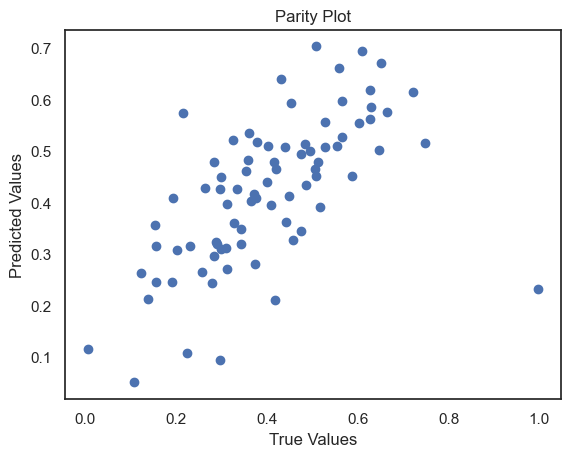

In [382]:
plt.scatter(y_val, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

In [383]:
y_pred = evaluate_test('regression', model, X_test, y_test)

Mean Absolute Error (MAE): 0.0832
Root Mean Squared Error (RMSE): 0.1102
R-squared: 0.4754


(44, 44)


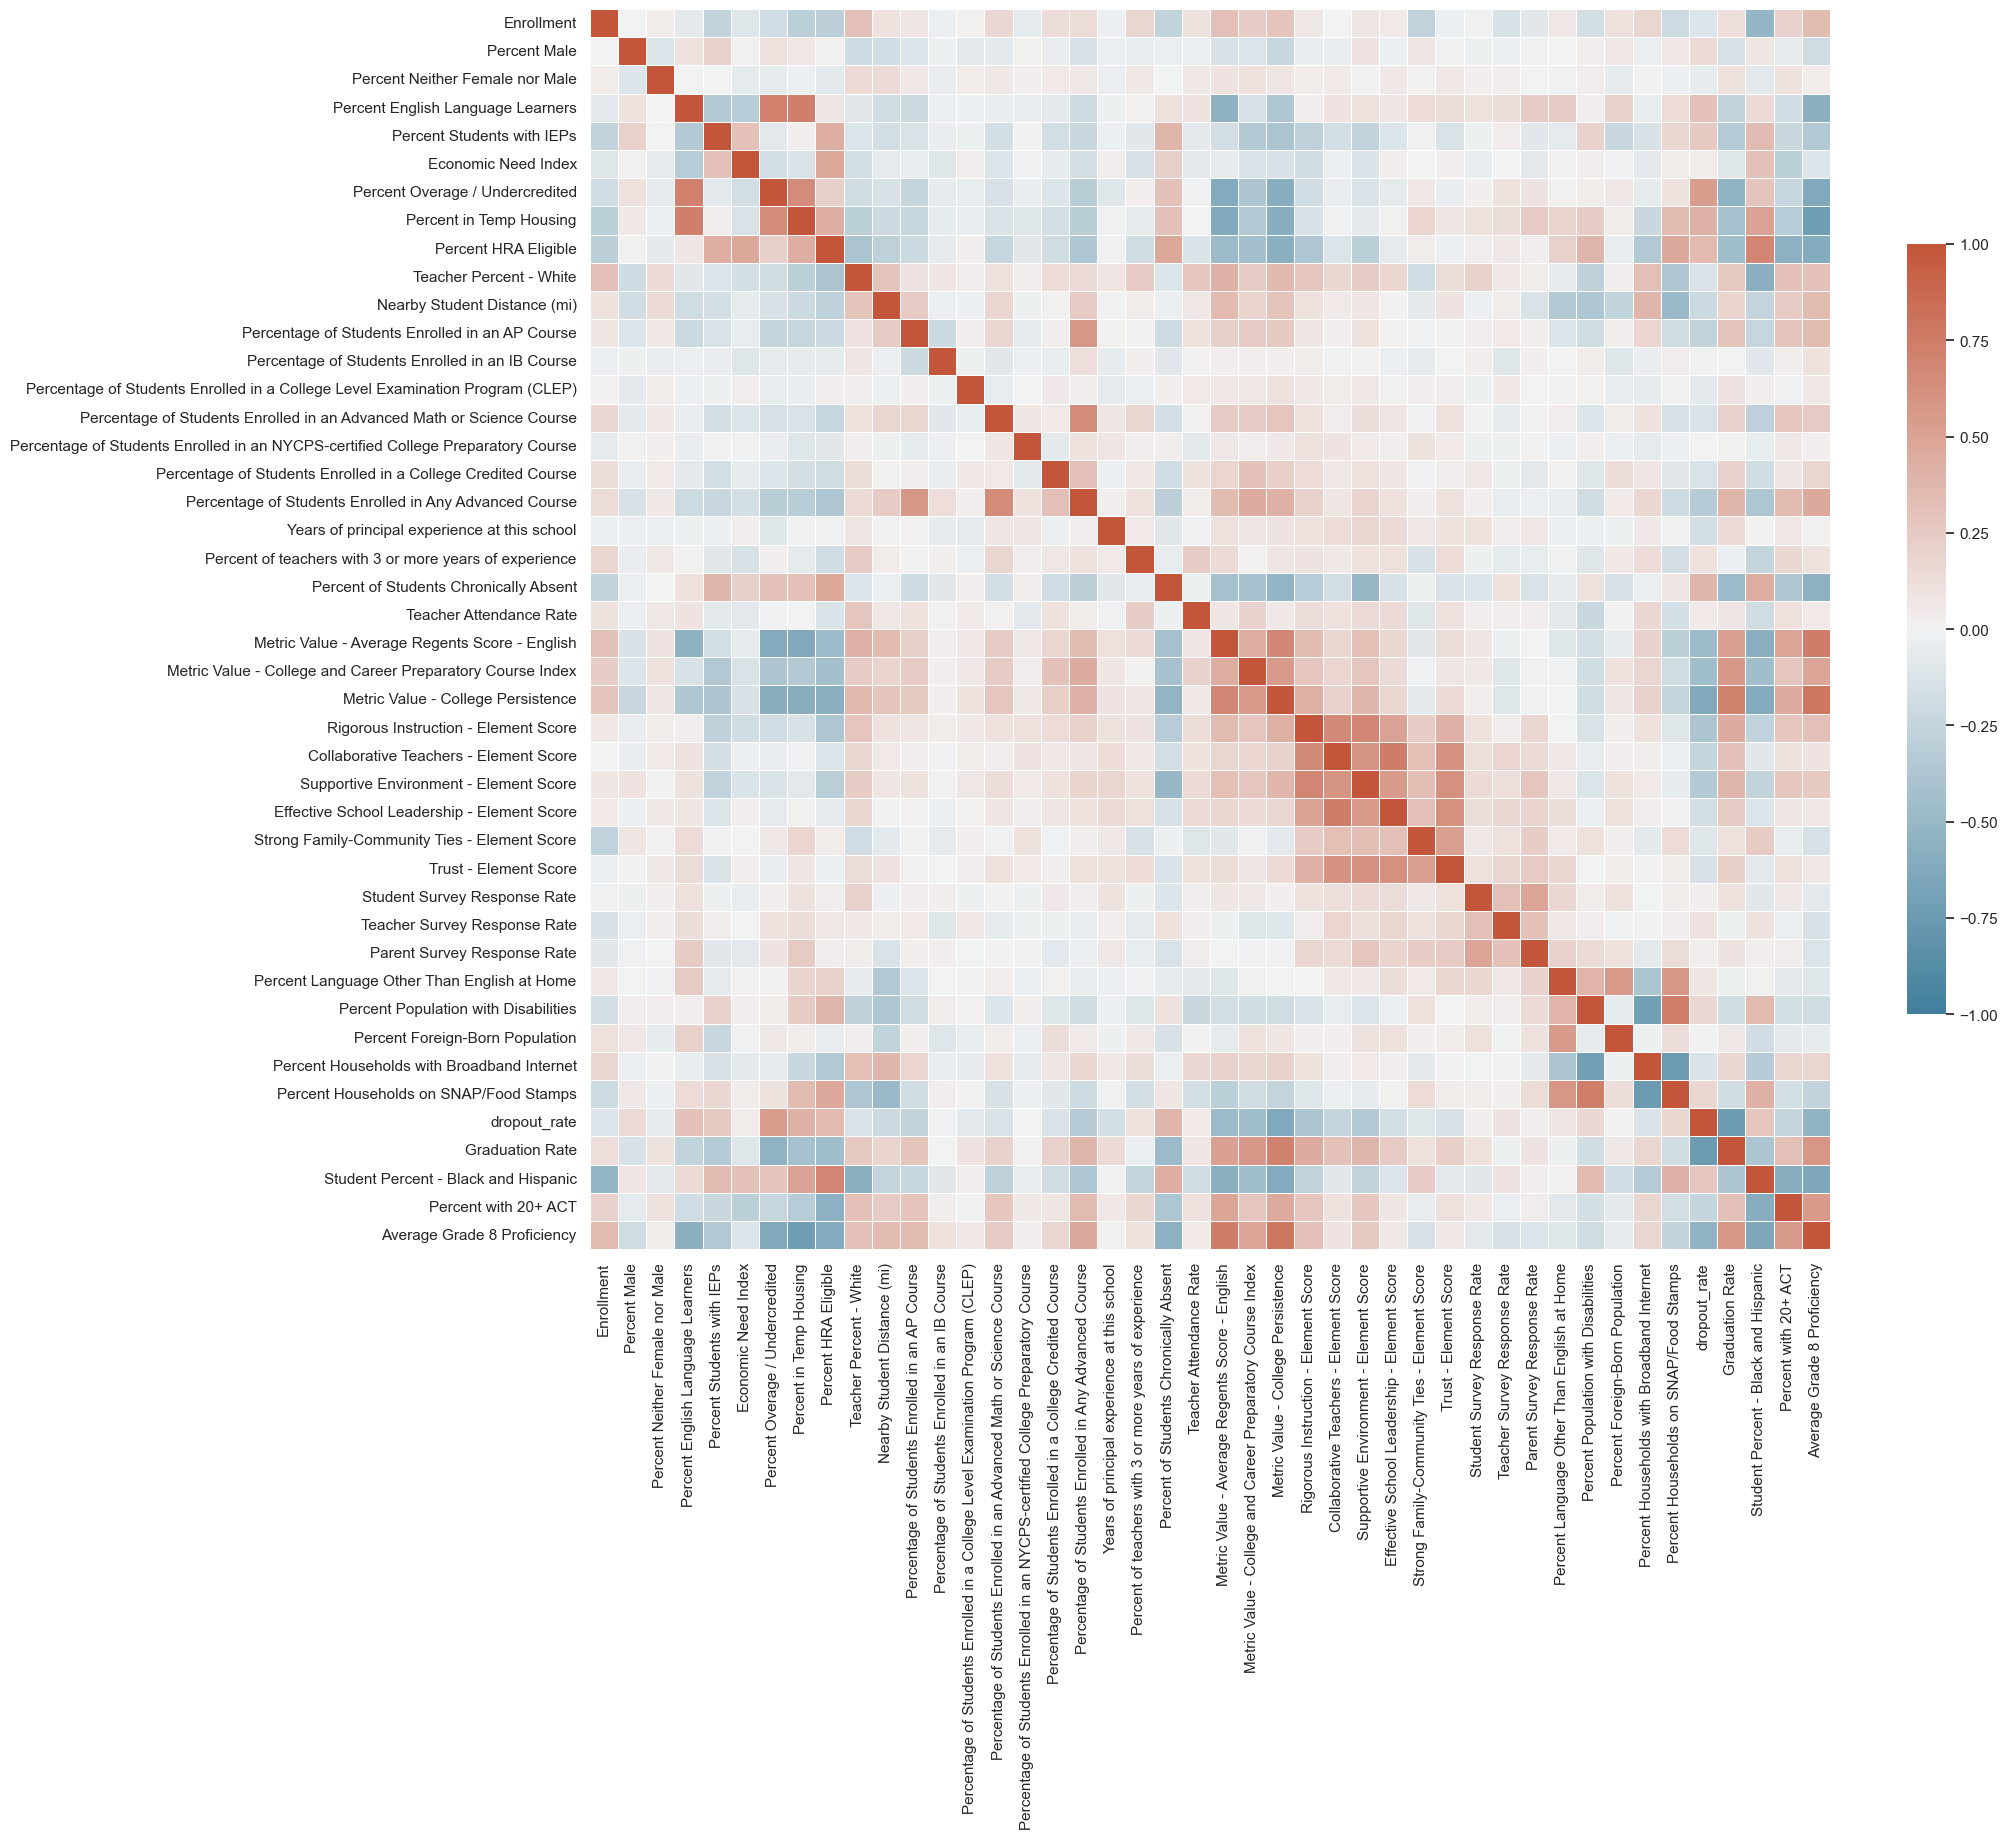

In [384]:
corr = df_clean.corr()
print(corr.shape)
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(20, 20))  # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) 	# Generate a custom diverging colormap
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmin=-1, vmax=1, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [369]:
list(df_clean.columns)

['Enrollment',
 'Percent Male',
 'Percent Neither Female nor Male',
 'Percent English Language Learners',
 'Percent Students with IEPs',
 'Economic Need Index',
 'Percent Overage / Undercredited',
 'Percent in Temp Housing',
 'Percent HRA Eligible',
 'Teacher Percent - White',
 'Nearby Student Distance (mi)',
 'Percentage of Students Enrolled in an AP Course',
 'Percentage of Students Enrolled in an IB Course',
 'Percentage of Students Enrolled in a College Level Examination Program (CLEP)',
 'Percentage of Students Enrolled in an Advanced Math or Science Course',
 'Percentage of Students Enrolled in an NYCPS-certified College Preparatory Course',
 'Percentage of Students Enrolled in a College Credited Course',
 'Percentage of Students Enrolled in Any Advanced Course',
 'Years of principal experience at this school',
 'Percent of teachers with 3 or more years of experience',
 'Percent of Students Chronically Absent',
 'Teacher Attendance Rate',
 'Metric Value - Average Regents Score - 

RF Regression

In [385]:
X, X_scaled, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df_clean, 'Percent of Students Chronically Absent')

In [386]:
model = train(X_train, y_train, 'regression', 'random_forest')
y_pred = validation_eval('regression',model,  X_val, y_val)

Mean Absolute Error (MAE): 0.0759
Root Mean Squared Error (RMSE): 0.0931
R-squared: 0.5622


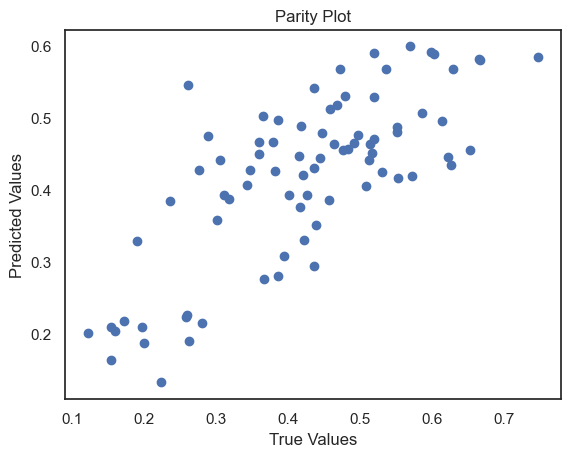

In [387]:
plt.scatter(y_val, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

Tune and Retrain Model

In [388]:
tune(model, X_train, y_train, rf_param_grid, scoring='neg_mean_squared_error')

Best params: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt')

In [390]:
model = train(X_train, y_train, 'regression', 'random_forest', bootstrap = False, max_depth= 20, max_features= 'sqrt', n_estimators= 100)

Get feature importance from RF

In [391]:
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

In [392]:
importance_df

,Feature,Importance
42,Average Grade 8 Proficiency,0.105878
39,Graduation Rate,0.070110
26,Supportive Environment - Element Score,0.061539
23,Metric Value - College Persistence,0.060105
6,Percent Overage / Undercredited,0.058239
8,Percent HRA Eligible,0.046214
7,Percent in Temp Housing,0.041372
4,Percent Students with IEPs,0.036657
22,Metric Value - College and Career Preparatory ...,0.030359
40,Student Percent - Black and Hispanic,0.028103


In [361]:
y_pred = evaluate_test('regression', model, X_test, y_test)

Mean Absolute Error (MAE): 0.0947
Root Mean Squared Error (RMSE): 0.1161
R-squared: 0.4978


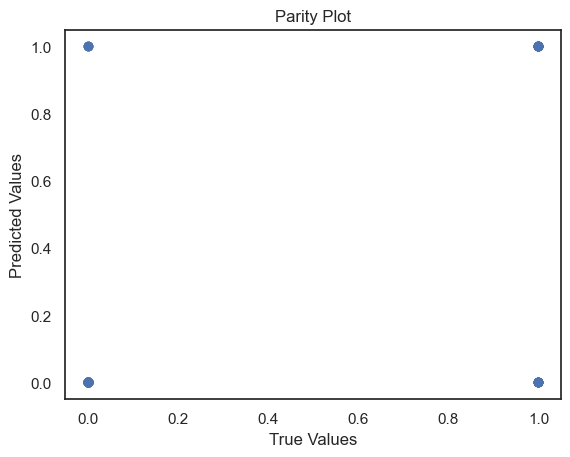

In [402]:
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

Gradient Boosting Regression

In [363]:
X, X_scaled, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df_clean, 'Percent of Students Chronically Absent')

In [364]:
model = train(X_train, y_train, 'regression', 'gradient_boosting')
y_pred = validation_eval('regression', model,  X_val, y_val)

Mean Absolute Error (MAE): 0.1004
Root Mean Squared Error (RMSE): 0.1249
R-squared: 0.2646


In [365]:
model = tune(model, X_train, y_train, boost_param_grid, scoring='neg_mean_squared_error')

Best params: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}


In [366]:
model = train(X_train, y_train, 'regression', 'gradient_boosting', max_depth= 3, max_features= 'sqrt', n_estimators= 100)
y_pred = validation_eval('regression', model,  X_val, y_val)

Mean Absolute Error (MAE): 0.1048
Root Mean Squared Error (RMSE): 0.1292
R-squared: 0.2133


In [367]:
y_pred = evaluate_test('regression', model, X_test, y_test)

Mean Absolute Error (MAE): 0.0832
Root Mean Squared Error (RMSE): 0.1075
R-squared: 0.5041


## Classification

In [423]:
#create column
df_class = df_clean.copy()
df_class['high_dropout'] = [1 if x >= 7.7 else 0 for x in df_class['dropout_rate']]
df_class.drop(['dropout_rate','Graduation Rate'], axis=1, inplace=True)

In [424]:
X, X_scaled, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_class, target_column='high_dropout')

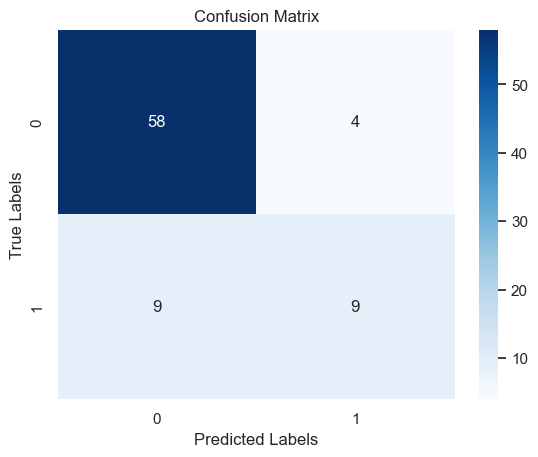

In [425]:
model = train(X_train, y_train, 'classification', 'random_forest')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [426]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.82      0.96      0.88        72
           1       0.82      0.48      0.61        29

    accuracy                           0.82       101
   macro avg       0.82      0.72      0.75       101
weighted avg       0.82      0.82      0.81       101



In [430]:
model = tune(model, X_train, y_train, rf_param_grid, scoring='f1')

Best params: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}


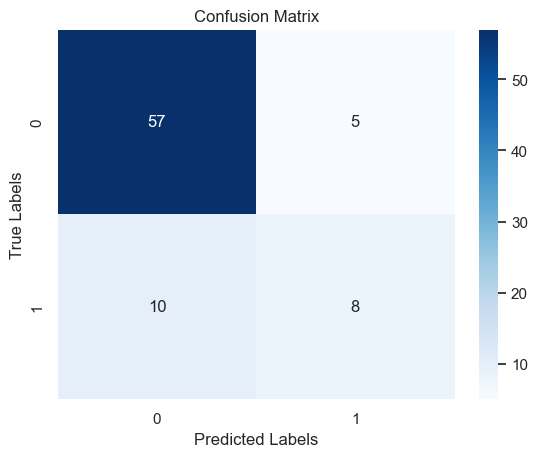

In [431]:
model = train(X_train, y_train, 'classification', 'random_forest', bootstrap=True, max_depth=20, max_features='log2', n_estimators=100)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [432]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.81      0.96      0.88        72
           1       0.81      0.45      0.58        29

    accuracy                           0.81       101
   macro avg       0.81      0.70      0.73       101
weighted avg       0.81      0.81      0.79       101



Gradient Boosting Classification

In [438]:
X, X_scaled, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_class, target_column='high_dropout')

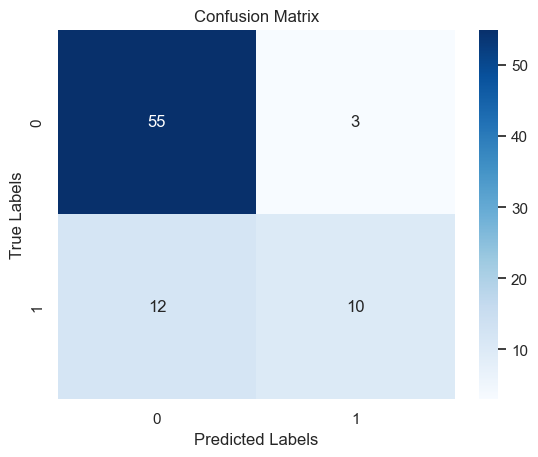

In [439]:
model = train(X_train, y_train, 'classification', 'gradient_boosting')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [440]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.81      0.87      0.84        76
           1       0.50      0.40      0.44        25

    accuracy                           0.75       101
   macro avg       0.66      0.63      0.64       101
weighted avg       0.74      0.75      0.74       101



In [445]:
model = tune(model, X_train, y_train, boost_param_grid)

Best params: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


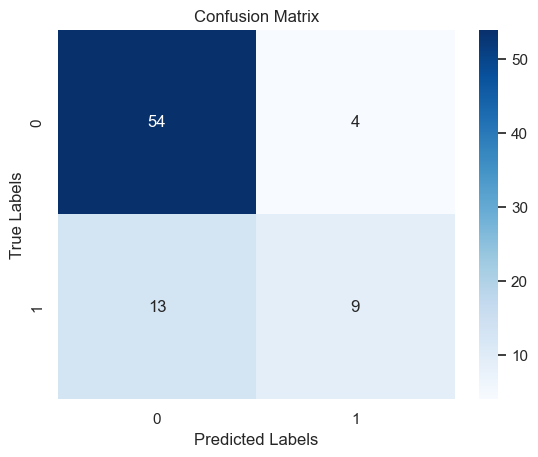

In [446]:
model = train(X_train, y_train, 'classification', 'random_forest', max_depth=10, max_features='sqrt', n_estimators=100)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [447]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.84      0.89      0.87        76
           1       0.60      0.48      0.53        25

    accuracy                           0.79       101
   macro avg       0.72      0.69      0.70       101
weighted avg       0.78      0.79      0.78       101

